In [1]:
import pandas as pd
from gensim.models import FastText


C:\Users\Andreas\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Andreas\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
df = pd.read_hdf("../datasets/new/Lurker.h5", key="Lurker")

In [3]:
model_sent = FastText.load("../models/user_level/fasttext_Lurker_senti.bin")
#model_weat = FastText.load("models/subreddit_level/fasttext_TwoXChromosomes_weat.bin")

In [4]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])
#NRC.columns = ["Words", "valence", "arousal", "dominance"]

In [5]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [9]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"] 
   
    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [10]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [11]:
woman_terms_freq, man_terms_freq

([['she', 'girl', 'her', 'female', 'woman', 'daughter', 'sister', 'hers'],
  [336874, 56045, 92702, 14180, 124841, 18055, 12685, 884]],
 [['man', 'he', 'his', 'boy', 'male', 'him', 'son', 'brother'],
  [137617, 436846, 123980, 19883, 16709, 396, 18735, 13264]])

In [12]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [13]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'her', 'daughter', 'aoc', 'woman', 'mother', 'man', 'son', 'fiance', 'say']
Top 10 (man) ['he', 'his', 'trump', 'never', 'could', 'say', 'guy', 'son', 'one', 'president']


In [14]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
163,hell,0.020,0.918,0.565
127,hate,0.031,0.802,0.430
71,dead,0.052,0.454,0.194
67,traitorous,0.073,0.745,0.412
106,ill,0.073,0.410,0.200


In [15]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
163,hell,0.020,0.918,0.565
217,action,0.760,0.898,0.802
212,fight,0.531,0.868,0.809
75,hating,0.083,0.820,0.434
127,hate,0.031,0.802,0.430


In [16]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
5,president,0.677,0.622,0.973
204,winning,0.955,0.712,0.972
50,presidential,0.612,0.656,0.972
209,chairman,0.656,0.567,0.933
37,leader,0.833,0.582,0.926


In [17]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
200,hell,0.020,0.918,0.565
198,displease,0.021,0.702,0.286
223,steal,0.021,0.856,0.528
222,hate,0.031,0.802,0.430
98,dead,0.052,0.454,0.194


In [18]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
197,threaten,0.104,0.958,0.590
229,arrest,0.146,0.951,0.500
200,hell,0.020,0.918,0.565
116,rapist,0.062,0.906,0.571
111,uproar,0.271,0.902,0.462


In [19]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
117,president,0.677,0.622,0.973
139,commissioner,0.602,0.449,0.949
165,leader,0.833,0.582,0.926
106,trump,0.640,0.716,0.898
87,chancellor,0.646,0.500,0.887


In [20]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.04268021368350619 0.026842156172632983 0.03611375560388089


In [21]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.052727428663376916 0.031834512479439324 0.02720055045412288


In [22]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()

    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))


Bad key figure.labelsize in file C:\Users\Andreas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle, line 310 ('figure.labelsize:   medium    # size of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution

Bad key figure.labelweight in file C:\Users\Andreas\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\classic (2).mplstyle, line 311 ('figure.labelweight: normal    # weight of the figure label')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.3/matplotlibrc.template
or from the matplotlib source distribution


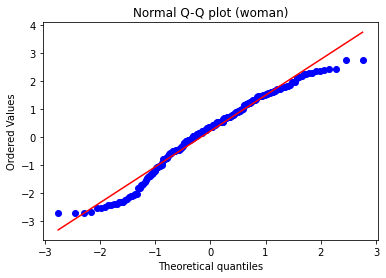

kolmogorv KstestResult(statistic=0.5751848304862205, pvalue=8.297228386255304e-75)


In [23]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

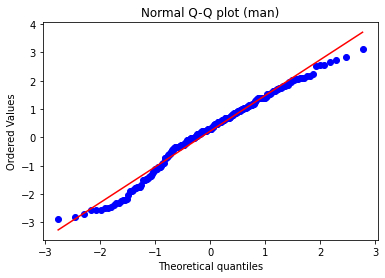

kolmogorv KstestResult(statistic=0.5592716297628931, pvalue=1.0197616768809552e-72)


In [24]:
check_normal_dist(df_NRC_man, "arousal","man")

In [25]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    import math
    import statistics
   
    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("welsh")
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [26]:
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=0.914781, p=0.361
Same distribution (fail to reject H0)
237 245
welsh
Statistics=0.799002, p=0.425
Same distribution (fail to reject H0)
237 245
welsh
Statistics=-0.622459, p=0.534
Same distribution (fail to reject H0)
237 245


In [27]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.5285673469387752 0.4918448979591835 0.5389183673469391
0.5444810126582276 0.5061308016877636 0.5288396624472577
